In [1]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
import bisect
import functools
import itertools
import pickle as pkl
import time
from IPython.display import clear_output
%matplotlib notebook
from PIL import Image
import sklearn

In [2]:
combined = {}
image_dir = "2014/images/"
mask_dir = "2014/masks/"
for fn in os.listdir(image_dir):
    raw_img = gdal.Open(image_dir + fn)
    arr_img = raw_img.ReadAsArray()
    raw_msk = gdal.Open(mask_dir + fn)
    arr_msk = raw_msk.ReadAsArray()
    combined[fn.split('.')[0]] = np.concatenate((arr_img, arr_msk), axis=0)
    
combined_new = {}
image_dir = "2015/images/"
mask_dir = "2015/masks/"
for fn in os.listdir(image_dir):
    raw_img = gdal.Open(image_dir + fn)
    arr_img = raw_img.ReadAsArray()
    raw_msk = gdal.Open(mask_dir + fn)
    arr_msk = raw_msk.ReadAsArray()
    combined_new[fn.split('.')[0]] = np.concatenate((arr_img, arr_msk), axis=0)
    
table = pd.read_csv('2014/tables/LC8_SR.csv')
time_start = table[['system:index', 'system:time_start']]
table_new = pd.read_csv('2015/tables/LC8_SR.csv')
time_start_new = table_new[['system:index', 'system:time_start']]

ds = {}
for k, v in combined.items():
    ts = time_start[time_start['system:index'] == k]['system:time_start'].iloc[0]
    ds[ts] = v
    
ds_new = {}
for k, v in combined_new.items():
    ts = time_start_new[time_start_new['system:index'] == k]['system:time_start'].iloc[0]
    ds_new[ts] = v

In [3]:
def get_boolean_mask(image, level=1):
    cfmask = image[3, :, :]
    cfmask_conf = image[4, :, :]
    return (cfmask == 0) & (cfmask_conf <= level)

def zigzag_integer_pairs(max_x, max_y):
    total = 0
    x = 0
    while total <= max_x + max_y:
        if total - x <= max_y:
            yield (x, total - x)
        if x <= min(max_x - 1, total - 1):
            x += 1
        else:
            total += 1
            x = 0

def interpolate(timestamp, dataset):
    times = list(dataset.keys())
    times.sort()
    pos = bisect.bisect(times, timestamp)
    n_times = len(times)
    dims = dataset[times[0]].shape
    interpolated = np.zeros((3, dims[1], dims[2]))
    times_before = times[:pos]
    times_before.reverse()
    times_after = times[pos:]
    unfilled = np.ones(dims[1:], dtype=bool)
    for pair in zigzag_integer_pairs(len(times_before) - 1, len(times_after) - 1):
        before = times_before[pair[0]]
        after = times_after[pair[1]]
        alpha = 1.0 * (timestamp - before) / (after - before)
        mask_before = get_boolean_mask(dataset[before])
        mask_after = get_boolean_mask(dataset[after])
        common_unmasked = mask_before & mask_after
        valid = common_unmasked & unfilled
#         fitted = dataset[before][:3, :, :] * alpha + dataset[after][:3, :, :] * (1 - alpha)
        fitted = np.zeros((3, dims[1], dims[2]))
        fitted[:, valid] = dataset[before][:3, valid] * alpha + dataset[after][:3, valid] * (1 - alpha)
        unfilled = unfilled ^ valid
        interpolated[:, valid] = fitted[:, valid]
    # todo: deal with timestamps before the first image or after the last
    # todo: deal with only having masked pixels on one side
    # the above two can be achieved with one-sided value filling
    # interpolate at existing time - remove cloud (should be working already)
    times.sort(key=lambda t: abs(t - timestamp))
    for ts in times:
        mask = get_boolean_mask(dataset[ts])
        valid = mask & unfilled
        unfilled = unfilled ^ valid
        interpolated[:, valid] = dataset[ts][:3, valid]
    return interpolated

def interpolate_images(timestamps, dataset):
    return {ts: interpolate(ts, dataset) for ts in timestamps}

In [4]:
times = list(ds_new.keys())
times.sort()
times_to_fit = []
for t in times:
    dt = datetime.datetime.fromtimestamp(t/1000)
    dt = dt.replace(year=dt.year - 1)
    times_to_fit += [int(dt.timestamp() * 1000)]

fitted_images = interpolate_images(times_to_fit, ds)

In [5]:
fitted_images_adjusted_axes = {k: np.rollaxis(v, 0, 3) for k, v in fitted_images.items()}

In [6]:
fitted_images_adjusted_axes[times_to_fit[0]].shape

(973, 1022, 3)

In [7]:
def standardise_bands(img):
    original = img.astype(np.float)
    max_val = np.max(original, axis=(0, 1))
    min_val = np.min(original, axis=(0, 1))
    return (original - min_val) / (max_val - min_val)

In [8]:
fitted_images_standardised = {k: standardise_bands(v) for k, v in fitted_images_adjusted_axes.items()}

In [16]:
plt.figure(figsize=(12, 12))
plt.imshow(fitted_images_standardised[times_to_fit[8])

SyntaxError: invalid syntax (<ipython-input-16-79dfd938e080>, line 2)

In [11]:
import skimage.segmentation as segmentation
import skimage.morphology as morphology

In [161]:
test_img = fitted_images_standardised[times_to_fit[1]]
# seg = segmentation.felzenszwalb(test_img, scale=1.5, sigma=3, min_size=20)
seg = segmentation.slic(test_img, n_segments=1000, compactness=10, max_iter=30, sigma=0)

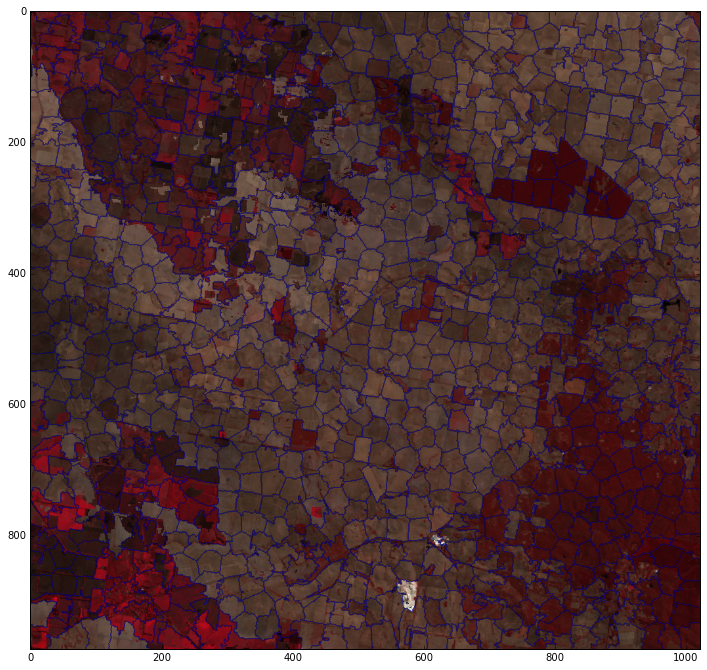

In [162]:
plt.figure(figsize=(12, 12))
plt.imshow(test_img)
boundary = segmentation.find_boundaries(seg)
plt.imshow(np.ma.masked_where(boundary == False, boundary), alpha=0.6)

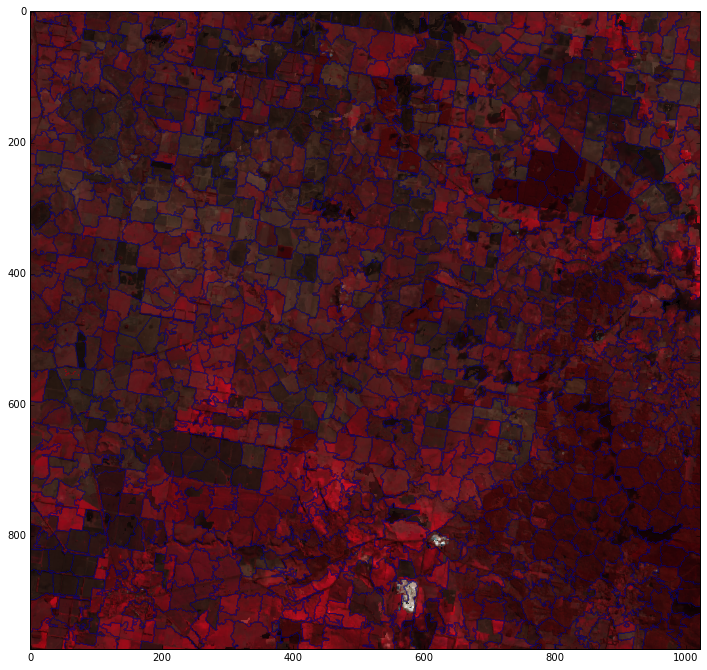

In [163]:
test_img = fitted_images_standardised[times_to_fit[2]]
# seg = segmentation.felzenszwalb(test_img, scale=1.5, sigma=3, min_size=20)
seg1 = segmentation.slic(test_img, n_segments=1000, compactness=10, max_iter=30, sigma=0)

plt.figure(figsize=(12, 12))
plt.imshow(test_img)
boundary1 = segmentation.find_boundaries(seg1)
plt.imshow(np.ma.masked_where(boundary1 == False, boundary1), alpha=0.6)

In [209]:
joint_seg = segmentation.join_segmentations(seg + 1, seg1 + 1)
joint_seg_rem = morphology.remove_small_objects(joint_seg, min_size=100)
joint_seg_absorbed = joint_seg_rem + (joint_seg_rem == 0) * (seg + 1)

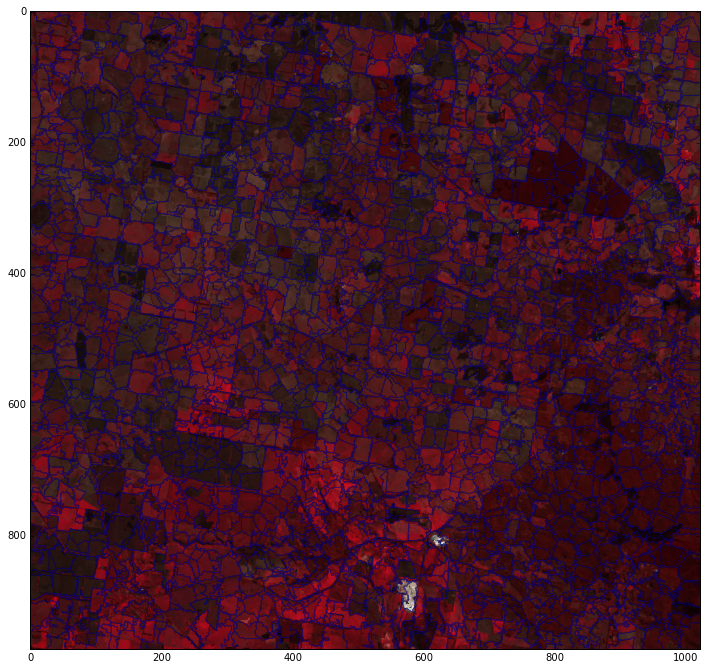

In [210]:
plt.figure(figsize=(12, 12))
plt.imshow(test_img)
boundary_joint = segmentation.find_boundaries(joint_seg_absorbed)
plt.imshow(np.ma.masked_where(boundary_joint == False, boundary_joint), alpha=0.6)

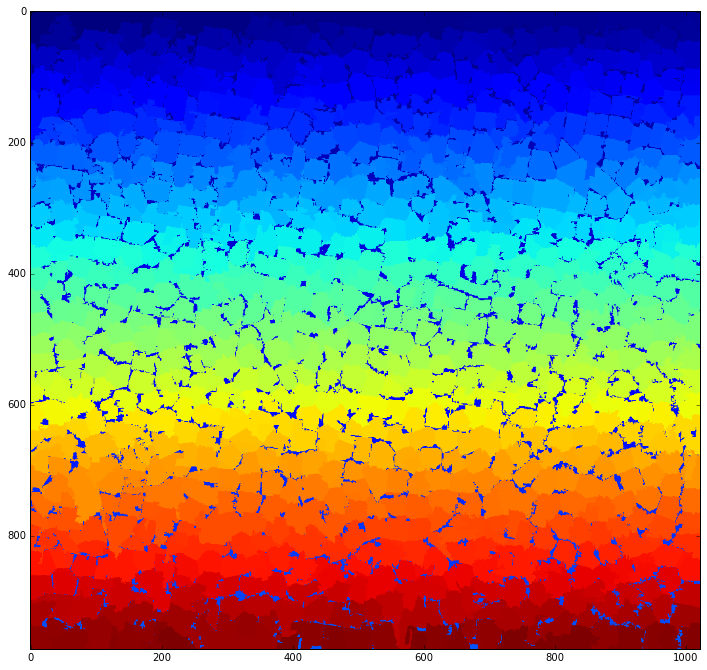

In [211]:
plt.figure(figsize=(12, 12))
plt.imshow(joint_seg_absorbed)